# Protective service occupations

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [ ]:
#!pip install --user fsspec==2022.07.0
#!conda update fsspec


In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Data import

In [33]:
df = pd.read_csv("C://nis/DA3/morg-2014-emp.csv")
df

<ipython-input-33-5753ed4c2bb9>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C://nis/DA3/morg-2014-emp.csv")


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149311,317051,896679860459501,December,WY,346.2296,692.30,40,39,1,NaN,...,0,0,"Native, Born In US",8,Office supplies and stationery stores (45321),4760,"Private, For Profit",No,No,Employed-At Work
149312,317052,907086820569600,December,WY,294.9800,1984.61,40,44,1,NaN,...,1,3,"Native, Born In US",8,Administration of human resource programs (923),430,Government - State,No,No,Employed-At Work
149313,317053,907086820569600,December,WY,324.1761,2884.61,55,43,1,NaN,...,1,3,"Native, Born In US",8,Nursing care facilities (6231),10,"Private, For Profit",No,No,Employed-At Work
149314,317055,950868097156649,December,WY,321.6982,1153.84,40,42,1,NaN,...,0,0,"Native, Born In US",8,Hospitals (622),5820,"Private, Nonprofit",No,No,Employed-At Work


In [34]:
df = df[(df['occ2012'] >= 3700) & (df['occ2012'] <= 3955)].copy()

# earnings per hour
df['earn_per_hour'] = df['earnwke'] / df['uhours']


In [35]:
df = df[['age', 'grade92', 'sex', 'race', 'marital', 'earnwke', 'uhours', 'earn_per_hour', 'state', 'ind02', 'occ2012', 'class', 'unionmme']].dropna()

### Data Cleaning

Despite deleting missing values in the variables that we are interested in, we have to drop outliers as well

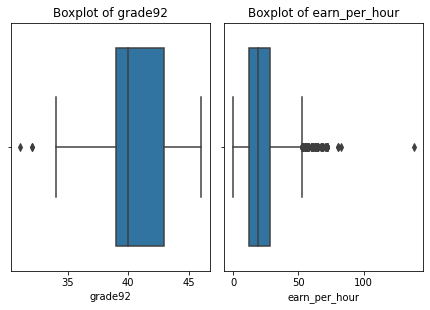

In [50]:
columns = ['grade92','earn_per_hour']

plt.figure(figsize=(12, 8))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 4, i) 
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [52]:
columns_with_outliers = ['grade92', 'earn_per_hour']

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df = remove_outliers(df, columns_with_outliers)


In [53]:
#for the model: 
y = df['earn_per_hour']
X = df.drop(columns=['earn_per_hour', 'earnwke', 'uhours'])

## Pre-analysis

After dropping all the missing values and outliers, the histograms of distribution were plotted. 

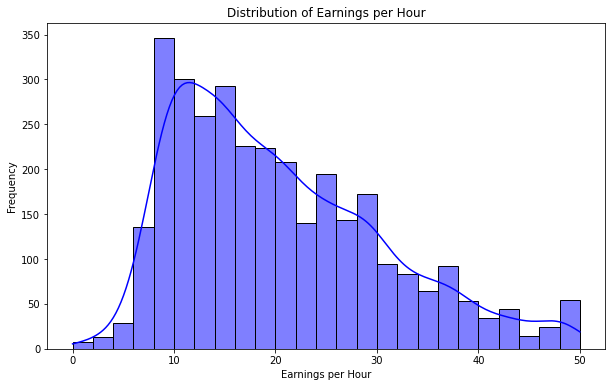

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='blue')
plt.title('Distribution of Earnings per Hour')
plt.xlabel('Earnings per Hour')
plt.ylabel('Frequency')
plt.show()

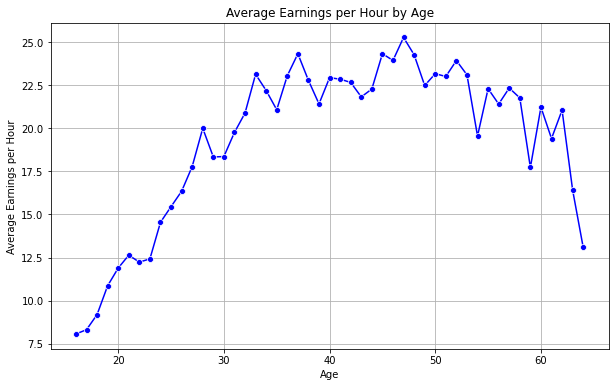

In [66]:
average_earnings_by_age = df.groupby('age')['earn_per_hour'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='age', y='earn_per_hour', data=average_earnings_by_age, marker='o', color='b')

plt.title('Average Earnings per Hour by Age')
plt.xlabel('Age')
plt.ylabel('Average Earnings per Hour')
plt.grid(True)
plt.show()

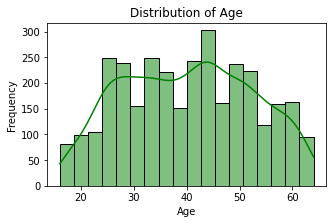

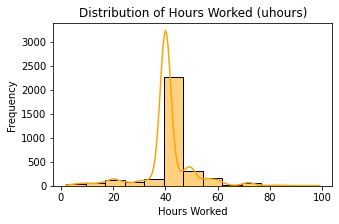

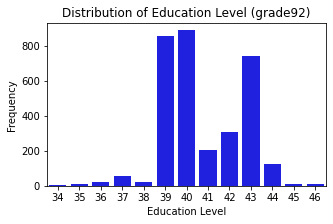

In [56]:
plt.figure(figsize=(5, 3))
sns.histplot(df['age'], kde=True, color='green')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df['uhours'], kde=True, color='orange')
plt.title('Distribution of Hours Worked (uhours)')
plt.xlabel('Hours Worked')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(x='grade92', data=df, color='blue')
plt.title('Distribution of Education Level (grade92)')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.show()

No autocorrelation

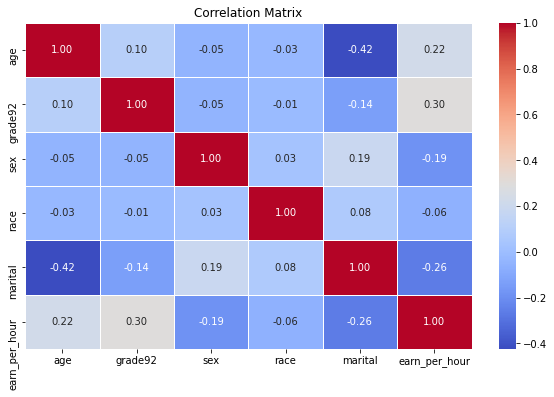

In [68]:
df['earn_per_hour'] = y

correlation_matrix = df[['age', 'grade92', 'sex', 'race', 'marital', 'earn_per_hour']].corr()
# Visualizing with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [58]:
round(df[['age', 'grade92', 'sex', 'race', 'marital', 'eph']].describe(), 2)

,age,grade92,sex,race,marital,eph
count,3248.00,3248.00,3248.00,3248.00,3248.00,3248.00
mean,40.21,40.74,1.23,1.51,3.38,20.37
std,12.19,1.85,0.42,1.61,2.72,10.23
min,16.00,34.00,1.00,1.00,1.00,0.00
25%,30.00,39.00,1.00,1.00,1.00,12.00
50%,41.00,40.00,1.00,1.00,1.00,18.25
75%,50.00,43.00,1.00,1.00,7.00,26.92
max,64.00,46.00,2.00,21.00,7.00,50.00


### Models 1-4 (very easy)

In [ ]:
models = [
    ['age'], 
    ['age', 'sex', 'race'],  
    ['age', 'sex', 'race', 'grade92', 'marital'], 
    ['age', 'sex', 'race', 'grade92', 'marital', 'state', 'class', 'ind02']  
]

In [ ]:
results = []
for i, features in enumerate(models):
    
    X_subset = pd.get_dummies(df[features], drop_first=True)  
    X_subset = X_subset.apply(pd.to_numeric, errors='coerce') 
    X_subset = X_subset.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
     
    X_subset = sm.add_constant(X_subset)  
    y = pd.to_numeric(df['earn_per_hour'], errors='coerce')


    # ОLS 
    model = sm.OLS(y, X_subset).fit()
    
    # RMSE
    y_pred = model.predict(X_subset)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Cross-validated RMSE
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    lin_reg = LinearRegression()
    cv_rmse = np.sqrt(-cross_val_score(lin_reg, X_subset, y, cv=kf, scoring='neg_mean_squared_error').mean())
    
    # BIC
    bic = model.bic
    
    results.append([f'Model {i+1}', rmse, cv_rmse, bic])


In [ ]:

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'CV RMSE', 'BIC'])
print(results_df)


### Models 1-4 (a bit more complex)

We will focus on these 4, because they are more complex and take into account more control variables for better explanation.

In [59]:
models = [
    ['age', 'sex', 'race'],  
    ['age', 'sex', 'race', 'grade92', 'marital'], 
    ['age', 'sex', 'race', 'grade92', 'marital', 'state', 'ind02'], 
    ['age', 'sex', 'race', 'grade92', 'marital', 'state', 'ind02', 'occ2012', 'class', 'unionmme'] 
]


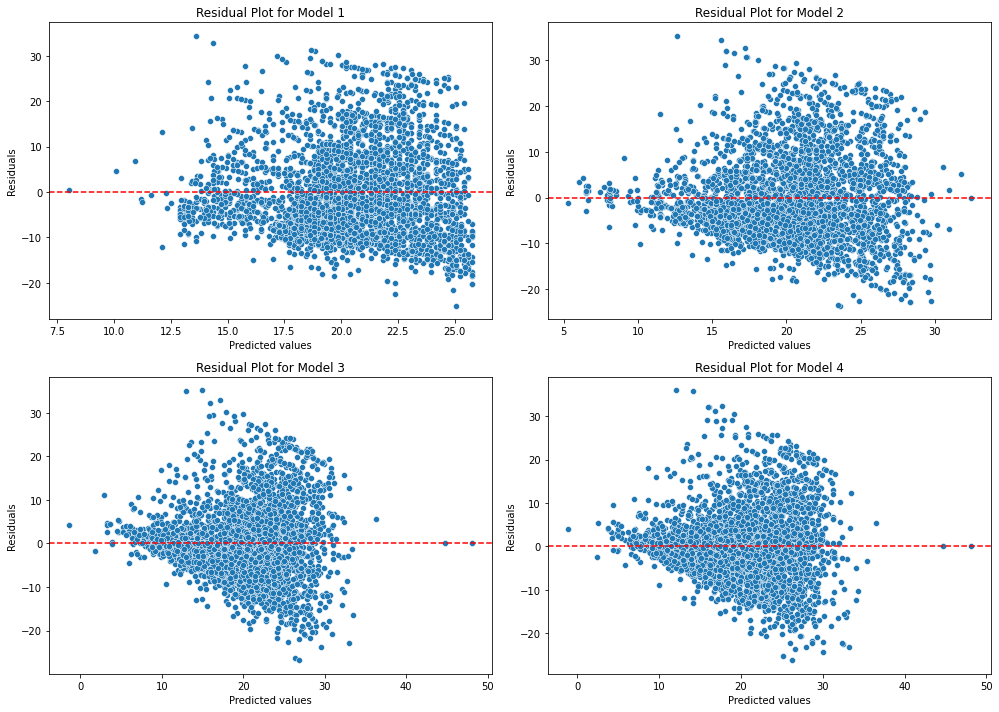

In [60]:
results = []
plt.figure(figsize=(14, 10))

for i, features in enumerate(models):
    X_subset = pd.get_dummies(df[features], drop_first=True)  
    X_subset = X_subset.apply(pd.to_numeric, errors='coerce') 
    X_subset = X_subset.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
     
    X_subset = sm.add_constant(X_subset)  
    y = pd.to_numeric(df['earn_per_hour'], errors='coerce')
    
    # OLS 
    model = sm.OLS(y, X_subset).fit()
    
    #  RMSE
    y_pred = model.predict(X_subset)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Cross-validated RMSE
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    lin_reg = LinearRegression()
    cv_rmse = np.sqrt(-cross_val_score(lin_reg, X_subset, y, cv=kf, scoring='neg_mean_squared_error').mean())
    
    #  BIC
    bic = model.bic
    
    results.append([f'Model {i+1}', rmse, cv_rmse, bic])
    
    plt.subplot(2, 2, i+1)  
    residuals = y - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for Model {i+1}')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [67]:

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'CV RMSE', 'BIC'])
round(results_df,3)


,Model,RMSE,CV RMSE,BIC
0,Model 1,9.796,9.808,24073.369
1,Model 2,9.307,9.326,23757.101
2,Model 3,8.633,9.158,24667.305
3,Model 4,8.480,9.015,24599.547


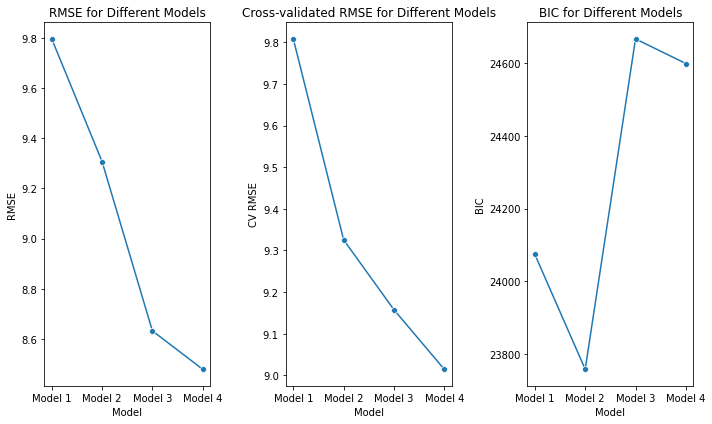

In [62]:

metrics_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'CV RMSE', 'BIC'])

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.lineplot(x=metrics_df['Model'], y=metrics_df['RMSE'], marker='o')
plt.title('RMSE for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
sns.lineplot(x=metrics_df['Model'], y=metrics_df['CV RMSE'], marker='o')
plt.title('Cross-validated RMSE for Different Models')
plt.xlabel('Model')
plt.ylabel('CV RMSE')

plt.subplot(1, 3, 3)
sns.lineplot(x=metrics_df['Model'], y=metrics_df['BIC'], marker='o')
plt.title('BIC for Different Models')
plt.xlabel('Model')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()